In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def quadraticBezier(t,points):
    B_x=(1-t)*((1-t)*points[0][0]+t*points[1][0])+t*((1-t)*points[1][0]+t*points[2][0])
    B_y=(1-t)*((1-t)*points[0][1]+t*points[1][1])+t*((1-t)*points[1][1]+t*points[2][1])
    return B_x,B_y

In [23]:
def cambrure(x,y, numPts):
    curve=[]
    t=np.array([i*1/numPts for i in range(0,numPts)])
    
    # calculate first Bezier curve
    B_x,B_y=quadraticBezier(t,[(0.,0.),(x,y),(1.,0.)])
    curve=list(zip(B_x,B_y))
    return curve

def find_camber_y(x, cambrure_coord):
    # pour un x donné il donne le y de la cambrure le plus proche
    for k,coord_camber in enumerate(cambrure_coord):
        if coord_camber[0] > x :
            return (coord_camber[1]+cambrure_coord[k-1][1])/2 # on prend la moyenne des deux 
    return 0.

def reconstruct_control_points(control_parameter):
    # Les points autour desquels on bouge
    x_param_cambrure, y_param_cambrure = control_parameter[-2:]  # les deux points definissant la cambrure 
    cambrure_coord = cambrure(x_param_cambrure, y_param_cambrure,16*40)
    base_points =[[1,0.004],              # trailing edge (top)
        [0.76,None],
        [0.52,None],
        [0.25,None],
        [0.1,None],
        [0,None],               # leading edge (top)
        [0,None],              # leading edge (bottom)
        [0.15,None],
        [0.37,None],
        [0.69,None],
        [1,-0.004],
        [1.008, 0]] 


    control_points = base_points[::] # les nouveaux control points on va construire avec le control_parameter 
    control_points[5][1] = control_parameter[0] + find_camber_y(control_points[5][0], cambrure_coord)
    control_points[6][1] = -control_parameter[0] + find_camber_y(control_points[6][0], cambrure_coord)
    for k in range(4):
        control_points[k+1][1] = control_parameter[1+k] + find_camber_y(control_points[k+1][0], cambrure_coord)

    for k in range(3):
        control_points[k+7][1] = control_parameter[5+k] +find_camber_y(control_points[k+7][0], cambrure_coord)
    return control_points


def airfoil1(ctlPts,numPts):
    curve=[]
    t=np.array([i*1/numPts for i in range(0,numPts)])
    
    # calculate first Bezier curve
    midX=(ctlPts[1][0]+ctlPts[2][0])/2
    midY=(ctlPts[1][1]+ctlPts[2][1])/2
    B_x,B_y=quadraticBezier(t,[ctlPts[0],ctlPts[1],[midX,midY]])
    curve=curve+list(zip(B_x,B_y))

    # calculate middle Bezier Curves
    for i in range(1,len(ctlPts)-3):
        p0=ctlPts[i]
        p1=ctlPts[i+1]
        p2=ctlPts[i+2]
        midX_1=(ctlPts[i][0]+ctlPts[i+1][0])/2
        midY_1=(ctlPts[i][1]+ctlPts[i+1][1])/2
        midX_2=(ctlPts[i+1][0]+ctlPts[i+2][0])/2
        midY_2=(ctlPts[i+1][1]+ctlPts[i+2][1])/2

        B_x,B_y=quadraticBezier(t,[[midX_1,midY_1],ctlPts[i+1],[midX_2,midY_2]])
        curve=curve+list(zip(B_x,B_y))                     
   
    # calculate last Bezier curve
    midX=(ctlPts[-3][0]+ctlPts[-2][0])/2
    midY=(ctlPts[-3][1]+ctlPts[-2][1])/2

    B_x,B_y=quadraticBezier(t,[ctlPts[-3],ctlPts[-2],[midX,midY]])
    curve=curve+list(zip(B_x,B_y))

    ## On fait le petit bout arrondi
    B_x,B_y = quadraticBezier(t,[ctlPts[-2],ctlPts[-1],ctlPts[0]])
    curve=curve+list(zip(B_x,B_y))
    return curve



def airfoil_plot(points, curve, title, control_parameter):
    xPts,yPts=list(zip(*points))
    xPts2,yPts2=list(zip(*curve))
    plt.plot(xPts2,yPts2,'b')
    plt.plot(xPts,yPts,color='#666666')
    plt.plot(xPts,yPts,'o',mfc='none',mec='r',markersize=8)

    x,y = control_parameter[-2:]
    cambrure_coord=cambrure(x,y,16*40)
    cambrure_coord = np.array(cambrure_coord)
    plt.plot(cambrure_coord[:,0], cambrure_coord[:,1], color='g')
    plt.plot((0,x,1),(0,y,0),'o',mfc='none',mec='g',markersize=8)

    plt.title(title)
    plt.xlim(-0.05,1.05)
    plt.grid()
    plt.ylim(-0.55,0.55)
    plt.show()

In [24]:
x_camb = 0.2
y_camb=0.4


control_parameter = np.array( [0.05,           # def le leading edge avec les deux coord en x=0
        0.08,
        0.125,
        0.12,
        0.08,               # leading edge (top) il prend les deux points
                            # leading edge (bottom)
        -0.08,
        -0.01,
        0.04,
        x_camb,
        y_camb]   
)

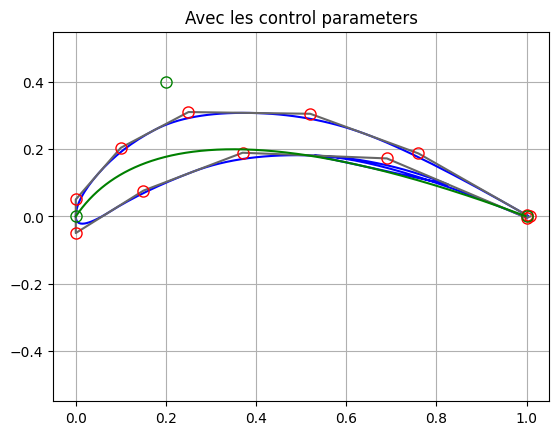

In [25]:
control_points = reconstruct_control_points(control_parameter)

curve=airfoil1(control_points,16)

airfoil_plot(control_points, curve, "Avec les control parameters", control_parameter)